In [240]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))

In [212]:
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    # y = emb_array[sample_number]
    # emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w    

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [4]:
sess = tf.Session()

In [10]:
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")

In [11]:
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)

In [12]:
load_model("20170511-185253", sess)

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [13]:
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

In [14]:
emb_array = forward(train_paths, 100) # 100 means 100 mini-batches

batch number: 0
batch number: 1
batch number: 2
batch number: 3
batch number: 4
batch number: 5
batch number: 6
batch number: 7
batch number: 8
batch number: 9
batch number: 10
batch number: 11
batch number: 12
batch number: 13
batch number: 14
batch number: 15
batch number: 16
batch number: 17
batch number: 18
batch number: 19
batch number: 20
batch number: 21
batch number: 22
batch number: 23
batch number: 24
batch number: 25
batch number: 26
batch number: 27
batch number: 28
batch number: 29
batch number: 30
batch number: 31
batch number: 32
batch number: 33
batch number: 34
batch number: 35
batch number: 36
batch number: 37
batch number: 38
batch number: 39
batch number: 40
batch number: 41
batch number: 42
batch number: 43
batch number: 44
batch number: 45
batch number: 46
batch number: 47
batch number: 48
batch number: 49
batch number: 50
batch number: 51
batch number: 52
batch number: 53
batch number: 54
batch number: 55
batch number: 56
batch number: 57
batch number: 58
batch n

batch number: 462
batch number: 463
batch number: 464
batch number: 465
batch number: 466
batch number: 467
batch number: 468
batch number: 469
batch number: 470
batch number: 471
batch number: 472
batch number: 473
batch number: 474
batch number: 475
batch number: 476
batch number: 477
batch number: 478
batch number: 479
batch number: 480
batch number: 481
batch number: 482
batch number: 483
batch number: 484
batch number: 485
batch number: 486
batch number: 487
batch number: 488
batch number: 489
batch number: 490
batch number: 491
batch number: 492
batch number: 493
batch number: 494
batch number: 495
batch number: 496
batch number: 497
batch number: 498
batch number: 499
batch number: 500
batch number: 501
batch number: 502
batch number: 503
batch number: 504
batch number: 505
batch number: 506
batch number: 507
batch number: 508
batch number: 509
batch number: 510
batch number: 511
batch number: 512
batch number: 513
batch number: 514
batch number: 515
batch number: 516
batch numb

batch number: 918
batch number: 919
batch number: 920
batch number: 921
batch number: 922
batch number: 923
batch number: 924
batch number: 925
batch number: 926
batch number: 927
batch number: 928
batch number: 929
batch number: 930
batch number: 931
batch number: 932
batch number: 933
batch number: 934
batch number: 935
batch number: 936
batch number: 937
batch number: 938
batch number: 939
batch number: 940
batch number: 941
batch number: 942
batch number: 943
batch number: 944
batch number: 945
batch number: 946
batch number: 947
batch number: 948
batch number: 949
batch number: 950
batch number: 951
batch number: 952
batch number: 953
batch number: 954
batch number: 955
batch number: 956
batch number: 957
batch number: 958
batch number: 959
batch number: 960
batch number: 961
batch number: 962
batch number: 963
batch number: 964
batch number: 965
batch number: 966
batch number: 967
batch number: 968
batch number: 969
batch number: 970
batch number: 971
batch number: 972
batch numb

In [141]:
emb_origin = np.empty_like(emb_array)
np.copyto(emb_origin, emb_array)

In [142]:
printData(train_labels, train_paths, 10)

  0   0   AJ_Cook_0001.png

  1   1   AJ_Lamas_0001.png

  2   2   Aaron_Eckhart_0001.png

  3   3   Aaron_Guiel_0001.png

  4   4   Aaron_Patterson_0001.png

  5   5   Aaron_Peirsol_0001.png
  6   5   Aaron_Peirsol_0002.png
  7   5   Aaron_Peirsol_0003.png
  8   5   Aaron_Peirsol_0004.png

  9   6   Aaron_Pena_0001.png


In [252]:
emb_array = np.delete(emb_array, (6), axis=0)

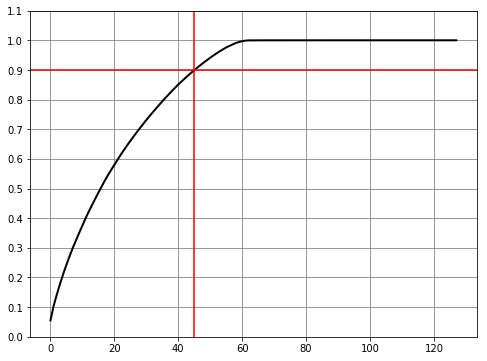

In [268]:
pca = PCA().fit(emb_array)

# 90% of variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.yticks(np.arange(0, 1.2, 0.1))
plt.axvline(45, c='r')
plt.axhline(0.9, c='r')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show()

emb_pca, _ = PCAtransform(emb_array, 120)

In [269]:
origin_pca, _ = PCAtransform(emb_origin, 120)

In [270]:
c, w = trainFisherWithNum(emb_pca, 5)

In [271]:
lng = len(origin_pca)
summ = 0
for i in range(lng):
    l = Fisher(w, c, origin_pca[i])
    if l > -5 and train_labels[i] >= 5 and train_labels[i] <= 8:
        summ += 1
    elif l < -5 and (train_labels[i] < 5 or train_labels[i] > 8):
        summ += 1
print(summ / lng)

0.9996221567293887
